In [1]:
#Load needed Libraries
#For converting address to geographic coordinates
from geopy.geocoders import Nominatim
#Loading bar
from tqdm import tqdm
#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
#TO deal with imbalance dataset
from imblearn.over_sampling import SMOTE
#Libraries
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Check to see if we loaded our data properly 
#This if from my previous project called Bike_accidents_San_Diego
bike_accidents = pd.read_csv(r"C:\Users\whift\PycharmProjects\Traffice_Collisions\cleaned_bike_accidents.csv")
bike_accidents.head()

,report_id,date,person_role,person_injury_lvl,person_veh_type,veh_type,veh_make,veh_model,police_beat,address_no_primary,...,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl,address
0,20200140,2020-01-06,BICYCLIST,SEVERE,NaN,BICYCLE,GIANNINI,NaN,531,1900.0,...,,,,22350,VC,UNSAFE SPEED (BASIC SPEED LAW) (I),1,0,NaN,"1900 PERSHING DRIVE, San Diego, CA"
1,20200152,2020-01-07,BICYCLIST,PAIN,NaN,BICYCLE,NaN,NaN,521,1400.0,...,,,,22517,VC,UNSAFE OPENING OF VEH DOOR (I),1,0,NaN,"1400 BROADWAY, San Diego, CA"
2,20200153,2020-01-07,BICYCLIST,PAIN,NaN,BICYCLE,NaN,NaN,243,NaN,...,,PADGETT,STREET,21801A,VC,RIGHT-OF-WAY:MAKING LEFT OR U-TURN (I),1,0,NaN,"MIRAMAR ROAD, San Diego, CA"
3,20200237,2020-01-10,BICYCLIST,VISABLE,NaN,BICYCLE,FUJI ROBBT JR.,NaN,523,700.0,...,,,,21657,VC,LANE USAGE:DISOBEY DESIGNATED TRAFFIC DIRECTIO...,1,0,NaN,"700 05TH AVENUE, San Diego, CA"
4,20200338,2020-01-13,BICYCLIST,PAIN,NaN,BICYCLE,GIANNINI,NaN,614,4700.0,...,,,,21801A,VC,RIGHT-OF-WAY:MAKING LEFT OR U-TURN (I),1,0,NaN,"4700 WEST POINT LOMA BOULEVARD, San Diego, CA"


<span style="color: white"> Start of Data Preprocessing </span>

In [3]:
#We want to include columns we only want, and convert column values to binary values 0 and 1
focus = bike_accidents[['person_injury_lvl', 'address']].copy()

#Fill in NA values for injury lvl
focus['person_injury_lvl'] = focus['person_injury_lvl'].fillna('Not Reported')

#Map values to Integers 
focus['person_injury_lvl'] = focus['person_injury_lvl'].map({'Not Reported':0,'VISABLE':1,'PAIN':2,'MINOR':3,'SEVERE':4,'SERIOUS':5})
# 0(0,1,2)  will be classified as light injuries, while 1(3,4,5) will be classifiers as heavy injuries
focus['person_injury_lvl'] = focus['person_injury_lvl'].apply(lambda x: 0 if x in [0, 1, 2] else 1 )

#Check if it works
focus['person_injury_lvl'].value_counts(dropna=False)

person_injury_lvl
0    747
1    117
Name: count, dtype: int64

<span style="color: white"> So we notice that the proportion of light injury(0) is larger than Heavy Injury(1). This can be difficult for KNN to make predicitions.
 For this reason I chose to use SMOTE(Synthetic samples of the minority class) to compensate for the ratio. This could also also be fixed by using Random Forest with its parameter 'class_weight=balance', which is not available with KNN. Random Forest would handle imabalance and noise better than KNN but for the sake of this project of me wanting to stick with KNN this project will use KNN. </span>

In [6]:
#Properly Format the Addresses
def clean_address_column(df, column='address'):
    def clean_address(addr):
        if pd.isna(addr):
            return addr

        # Remove leading zeros in ordinal street names 
        addr = re.sub(r'\b0+(\d+)(ST|ND|RD|TH)\b', r'\1\2', addr, flags=re.IGNORECASE)

        # Remove vague directions like "E FEET OF THE CURB LINE OF"
        addr = re.sub(r'\b(?:\d+\s*)?(?:[NEWS]\s+)?(?:FEET|FOOT)\s+OF\s+THE\s+CURB(?:LINE)?\s+OF\s+', '', addr, flags=re.IGNORECASE)
        addr = re.sub(r'\b\d+\s+(?:[A-Z]+\s+)*OF\s+', '', addr, flags=re.IGNORECASE)

        # Remove stray double spaces and trim
        addr = re.sub(r'\s{2,}', ' ', addr).strip()

         #Normalize abbreviations (EXT ST into STREET)
        addr = addr.replace('EXT ST', 'STREET')

        return addr

    df[column] = df[column].apply(clean_address)
    return df

format_focus = clean_address_column(focus)
format_focus.head()

,person_injury_lvl,address
0,1,"1900 PERSHING DRIVE, San Diego, CA"
1,0,"1400 BROADWAY, San Diego, CA"
2,0,"MIRAMAR ROAD, San Diego, CA"
3,0,"700 5TH AVENUE, San Diego, CA"
4,0,"4700 WEST POINT LOMA BOULEVARD, San Diego, CA"


In [7]:
#We want to convert the addresses into longitude and latitude

#loading bar
tqdm.pandas()
geolocator = Nominatim(user_agent="Agent_Geopi")

cache = {}

def cached_geocode(address):
    if pd.isna(address) or not address.strip():
        return pd.Series([None, None])
    
    if address in cache:
        return cache[address]

    for _ in range(3):  # Retry logic
        try:
            time.sleep(1.5)
            location = geolocator.geocode(address)
            if location:
                result = pd.Series([location.latitude, location.longitude])
                cache[address] = result
                return result
        except:
            continue
    result = pd.Series([None, None])
    cache[address] = result
    return result

# Apply the geocoding
#Note this takes about 20minutes to run 
format_focus[['latitude', 'longitude']] = format_focus['address'].progress_apply(cached_geocode)

100%|██████████| 864/864 [31:02<00:00,  2.16s/it]  


<span style="color: white"> By default geopy uses OpenStretMap's by Nominatim's service, which expalins why it takes so long to convert the addresses to into longitude and latitude. Note that using a paid API like Google Maps would greatly speed up the proccess.</span>

In [11]:
#Check to see if any addresses are not read correctly
format_focus['longitude'].isna().sum()
format_focus.head()
#There seems to be 41-49(It seems to change every run) addresses that were not read, but for the sake of time we will ignore the 49 addresses
#I created a csv file below that stores the failed addresses for future fixes

,person_injury_lvl,latitude,longitude
0,1,32.725330,-117.142089
1,0,32.716012,-117.151734
2,0,32.889956,-117.142683
3,0,32.625058,-117.082697
4,0,32.750665,-117.239887


In [9]:
#Creates the csv file for addresses that were not read
na_addresses = format_focus[focus['latitude'].isna() & format_focus['longitude'].isna()]
print(na_addresses[['address']])

na_addresses.to_csv('format_failed_geocodes.csv', index=False)

KeyError: "None of [Index(['address'], dtype='object')] are in the [columns]"

In [ ]:
#After csv is made now we drop the column address since we do not need it anymore 
format_focus = format_focus.drop(columns=['address'])

In [12]:
#Drop the NA values
format_focus = format_focus.dropna()
format_focus['longitude'].isna().sum()
#Result should be 0

np.int64(0)

<span style="color: white"> End of Data Preprocessing </span>

<span style="color: white"> Start of Builidng KNN Model </span>

In [13]:
#Create Features  and Target Variables
X = format_focus.drop(columns = ['person_injury_lvl'])
y = format_focus['person_injury_lvl']

X_train,X_test,y_train,y_test = train_test_split(X, y,  test_size=0.25, random_state = 42)


In [14]:
#Ml Preprocessing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
#Use smote to deal with the data imbalance
smote = SMOTE(random_state=42, k_neighbors = 1)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [16]:
#Hyperparameter Tuning
def tune_model(X_train,y_train):
    param_grid = {
        'n_neighbors': range(1,21),
        'metric' : ['euclidean','manhattan','minkowski'],
        'weights' : ['uniform','distance']
    }
    
    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model,param_grid,cv=5,n_jobs=-1)
    grid_search.fit(X_train,y_train)
    return grid_search.best_estimator_
    
    
best_knn = tune_model(X_train,y_train)



In [17]:
#Prediction and evaluation
y_pred = best_knn.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       181
           1       0.19      0.26      0.22        27

    accuracy                           0.76       208
   macro avg       0.54      0.55      0.54       208
weighted avg       0.79      0.76      0.78       208

[[152  29]
 [ 20   7]]


<span style="color: white"> Even with SMOTE the model still fails to properly predict the high level injury(1). At this point switching to Random Forest might be better to handle unbalance data as mentioned earlier </span>

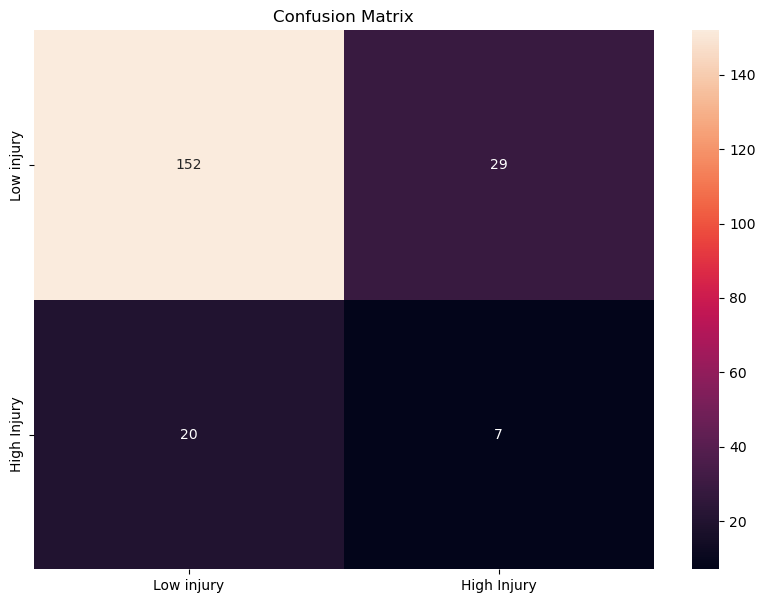

In [18]:
#Plot Heatmap
def plot_model(matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix,annot=True,fmt='d', xticklabels=['Low injury','High Injury'], yticklabels=['Low injury','High Injury'])
    plt.title('Confusion Matrix')
    plt.show()
    
plot_model(matrix)
    

<span style="color: white"> End of Model Building </span>